## Perturbative results

In [37]:
from scipy.io import loadmat

import matplotlib.pyplot as plt

mat_contents = loadmat('../../Matlab/Version_For_Ragheed/Polaron_Mu_0p4142_Nk_10_Self_Energy_Terms.mat')

dJUs_vector = mat_contents['objPol']['tdJ_grid'][0][0][0]
U12 = mat_contents['objPol']['U12'][0][0][0]
sigma0 = mat_contents['objPol']['fill_qm_corrected'][0][0][0]
sigma1 = mat_contents['objPol']['E0_Order_U12_sq_frohlich_only'][0][0][0]
sigma2 = mat_contents['objPol']['E0_Order_U12_sq_Beyond_Frohlich_only'][0][0][0]
en_vector = U12 * sigma0 + sigma1 + sigma2


In [4]:
# Compute the energy of the polaron in the limit of small U12

import numpy as np
import os
import utils
from grid import Grid
from params import Params
from gs import groundstate
from exc import excitations
from vert import vertices
from pert import perturbative
from plotting import plot2D, plot_cns, plot_omega0
import matplotlib.pyplot as plt

config_path = "config.yml" 

output_dir = utils.create_output_dir()

config = utils.read_config(config_path)

Lx = config["grid"]["Lx"]
Ly = config["grid"]["Ly"]

N = config["physics"]["N"]
dJUs = np.arange(**config["lists"]["dJUs"])
muU = eval(config["physics"]["muU"])
UIB = config["physics"]["UIB"]
cutoff = config["physics"]["cutoff"]

grid = Grid(Lx, Ly)

omega0s = np.zeros(len(dJUs))
omega1s = np.zeros(len(dJUs))
omega2s = np.zeros(len(dJUs))
omegas = np.zeros((len(dJUs), 3))
for count in range(len(dJUs)):
    dJU = dJUs[count]
    params = Params(N, dJU, muU, UIB, cutoff)
    gs = groundstate(params)
    cns = gs.cns()
    n0 = gs.n0(cns)
    psi0 = gs.psi0(cns)
    exc = excitations(grid, params, gs, cns)
    uks, vks, omegaklambda = exc.calculate_matrices()
    verts = vertices(grid, gs, uks, vks, cns, n0)
    pert = perturbative(grid, params, verts, omegaklambda)
    Pert_Energy = pert.perturbative_energy(n0)
    omega0s[count] = Pert_Energy[0]
    omega1s[count] = Pert_Energy[1]
    omega2s[count] = Pert_Energy[2]

In [64]:
# Stack arrays in sequence horizontally (column wise).
data = np.column_stack((dJUs, omega0s, omega1s, omega2s))

# Save the data to a text file.
filename = f'../data/Perturbative_UIB_{UIB:.2f}_mu_{muU:.2f}.txt'
np.savetxt(filename, data, delimiter=",", header="dJUs, omega0s, omega1s, omega2s")

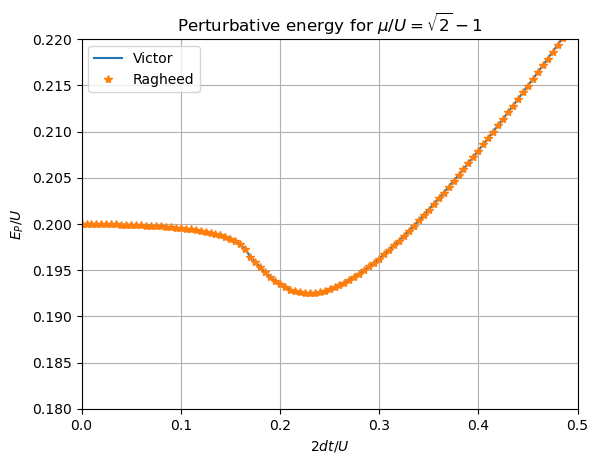

In [65]:
# Plot my results and those of Victor
# Load the data from the text file.
data = np.loadtxt(filename, delimiter=",")

# Split the data into separate arrays.
dJUs, omega0s, omega1s, omega2s = data.T

plt.plot(dJUs_vector, en_vector , label='Victor')
plt.plot(dJUs, omega0s + omega1s + omega2s, '*', label='Ragheed')
plt.xlabel(r"$2d t/U$")
plt.ylabel(r"$E_P/U$")
plt.title(r"Perturbative energy for $\mu/U = \sqrt{2}-1$")
plt.xlim([0, 0.5])
plt.ylim([0.18, 0.22])
plt.grid()
plt.legend()
plt.show()

In [55]:
# Write a code that calculates muU for a given sigma0

muU_qcorr = np.zeros(len(dJUs))
dJUmax = (np.sqrt(2) - 1)**2

def n0_corr(muU, dJU, UIB, cutoff):
    params = Params(N, dJU, muU, UIB, cutoff)
    gs = groundstate(params)
    cns = gs.cns()
    n0 = gs.n0(cns)
    exc = excitations(grid, params, gs, cns)
    uks, vks, omegaklambda = exc.calculate_matrices()
    verts = vertices(grid, gs, uks, vks, cns, n0)
    pert = perturbative(grid, params, verts, omegaklambda)
    eq = pert.sigma0(n0) / UIB
    return eq - 1

def findroot(mu_start, mu_step, dJU, UIB, cutoff):
    n_1 = n0_corr(mu_start, dJU, UIB, cutoff)
    n_2 = n0_corr(mu_start + mu_step, dJU, UIB, cutoff)
    
    if(n_1 * n_2 > 0):
        return findroot(mu_start + mu_step, mu_step, dJU, UIB, cutoff)
    else:
        n_mid = n0_corr(mu_start + mu_step / 2, dJU, UIB, cutoff)
        if(np.abs(n_mid) < 0.0001):
            return mu_start + mu_step / 2
        elif(n_mid * n_1 < 0):
            return findroot(mu_start, mu_step / 2, dJU, UIB, cutoff)
        else:
            return findroot(mu_start + mu_step / 2, mu_step / 2, dJU, UIB, cutoff)


# start with large values of dJU and decrease it 
for count in range(len(dJUs)):
    if(dJUs[count] < dJUmax):
        muU_qcorr[count] = np.sqrt(2) - 1
    else:
        dJU = dJUs[count]
        found = False
        mu_start = muU_qcorr[count] - 0.1
        mu_step = 0.05
        muU_qcorr[count] = findroot(mu_start, mu_step, dJU, UIB, cutoff)
        print("dJU = ", dJU, "muU = ", muU_qcorr[count])

plt.plot(dJUs, muU_qcorr, label=r"$\omega_{0}$")
plt.show()



dJU =  0.17500000000000002 muU =  0.4225
dJU =  0.18 muU =  0.41624999999999995
dJU =  0.185 muU =  0.41312499999999996
dJU =  0.19 muU =  0.4115625
dJU =  0.195 muU =  0.41039062499999995
dJU =  0.2 muU =  0.40765625
dJU =  0.20500000000000002 muU =  0.40609375000000003
dJU =  0.21 muU =  0.40375
dJU =  0.215 muU =  0.40140625
dJU =  0.22 muU =  0.399453125
dJU =  0.225 muU =  0.397109375
dJU =  0.23 muU =  0.39476562499999995
dJU =  0.23500000000000001 muU =  0.392421875
dJU =  0.24 muU =  0.390078125
dJU =  0.245 muU =  0.387734375
dJU =  0.25 muU =  0.385390625
dJU =  0.255 muU =  0.38304687499999995
dJU =  0.26 muU =  0.3803125
dJU =  0.265 muU =  0.37796875
dJU =  0.27 muU =  0.3754296875
dJU =  0.275 muU =  0.372890625
dJU =  0.28 muU =  0.37035156249999995
dJU =  0.28500000000000003 muU =  0.3678125
dJU =  0.29 muU =  0.365078125
dJU =  0.295 muU =  0.36234375
dJU =  0.3 muU =  0.3598046875
dJU =  0.305 muU =  0.3570703125
dJU =  0.31 muU =  0.3543359375
dJU =  0.315 muU =  0.3

RecursionError: maximum recursion depth exceeded

0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.17500000000000002, 0.18, 0.185, 0.19, 0.195, 0.2, 0.20500000000000002, 0.21, 0.215, 0.22, 0.225, 0.23, 0.23500000000000001, 0.24, 0.245, 0.25, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.28500000000000003, 0.29, 0.295, 0.3, 0.305, 0.31, 0.315, 0.32, 0.325, 0.33, 0.335, 0.34, 0.34500000000000003, 0.35000000000000003, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38, 0.385, 0.39, 0.395, 0.4, 0.405, 0.41000000000000003, 0.41500000000000004, 0.42, 0.425, 0.43, 0.435, 0.44, 0.445, 0.45, 0.455, 0.46, 0.465, 0.47000000000000003, 0.47500000000000003, 0.48, 0.485, 0.49, 0.495, 0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.555, 0.56, 0.5650000000000001, 0.5700000000000001, 0.5750000000000001, 0.58, 0.585, 0.59, 0.595, 0.6, 0.605, 0.61, 0.615, 0.62, 0.625, 0.63,

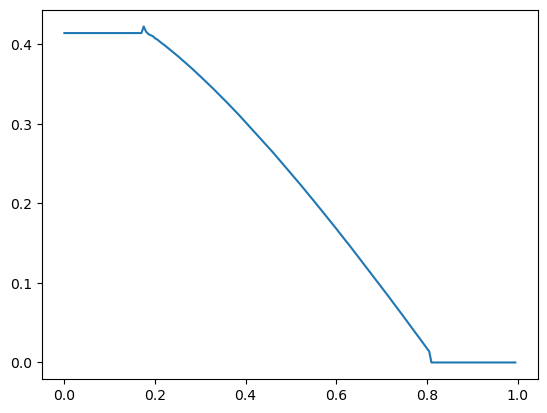

In [59]:
print(", ".join(map(str, dJUs)))
print(", ".join(map(str, muU_qcorr)))
plt.plot(dJUs, muU_qcorr, label=r"$\omega_{0}$")
plt.show()

In [6]:
M = grid.M
dim = M * M * (cutoff + 1)
def U(kx, ky, lambda_, qx, qy, lambda1, uks, n0):
    Ures = 0
    ns = np.arange(0, N, 1)
    Ures = sum(
        (ns - n0 * (1 - (lambda_ == lambda1) * (lambda_ == 0)))
        * uks[:, kx, ky, lambda_]
        * uks[:, qx, qy, lambda1]
    )
    return Ures

Us = np.zeros((dim, dim))
for lambda_ in range(cutoff):
    for lambda1 in range(cutoff):
        for kx in range(Lx):
            for ky in range(Ly):
                for qx in range(Lx):
                    for qy in range(Ly):
                        indk = lambda_ * Lx * Lx + kx * Ly + ky
                        indq = lambda1 * Ly * Ly + qx * Ly + qy
                        Uelem = UIB * U(kx, ky, lambda_, qx, qy, lambda1, uks, n0)
                        Us[indk, indq] = Uelem
print(Us)

[[0.33510127 0.33510127 0.33510127 ... 0.         0.         0.        ]
 [0.33510127 0.33510127 0.33510127 ... 0.         0.         0.        ]
 [0.33510127 0.33510127 0.33510127 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [8]:
# Assuming uk and vk are 4D arrays
# Define the dimensions
# N, Lx, Ly, cutoff = uk.shape

# Create a 6D array for Uk
Uk = np.zeros((Lx, Ly, cutoff, Lx, Ly, cutoff))

# Create arrays for the indices
n2, n3, n4, m2, m3, m4 = np.ogrid[0:Lx, 0:Ly, 0:cutoff, 0:Lx, 0:Ly, 0:cutoff]

# Calculate Uk for all combinations of n2, n3, n4, m2, m3, m4
Uk[n2, n3, n4, m2, m3, m4] = np.sum(uks[:, n2, n3, n4] * vks[:, m2, m3, m4], axis=0)
print (Uk.shape())
Uk = np.reshape(Uk, (Lx * Ly * cutoff, Lx * Ly * cutoff))
print (Uk)

[[ 0.          0.18966719 -0.20154196 ...  0.18966719 -0.20154196
  -0.07817473]
 [ 0.          0.0644292  -0.00769394 ...  0.0644292  -0.00769394
  -0.00559949]
 [ 0.         -0.00769394 -0.02921427 ... -0.00769394 -0.02921427
  -0.01041912]
 ...
 [ 0.          0.0644292  -0.00769394 ...  0.0644292  -0.00769394
  -0.00559949]
 [ 0.         -0.00769394 -0.02921427 ... -0.00769394 -0.02921427
  -0.01041912]
 [ 0.         -0.00559949 -0.01041912 ... -0.00559949 -0.01041912
  -0.00356503]]


In [78]:
value = exc.epsI(grid.KXs, grid.KYs)
matrix = np.full((len(grid.KXs), len(grid.KYs)), value)
# print(matrix)
matrix = exc.epsI(grid.KXs[:, None], grid.KYs[None, :])

matrix1 = np.zeros((cutoff, len(grid.KXs), len(grid.KYs)))
for lambda1 in range(cutoff):
    for i in range(len(grid.KXs)):
        for j in range(len(grid.KYs)):
            matrix1[lambda1][i][j] = Epol - omegaklambda[lambda1, i, j] - dJU * exc.epsI(grid.KXs[i], grid.KYs[j]) 
print(matrix1 - matrix)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
